In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict
import logging
import os
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
from glob import glob
import os

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
import torch
import plotly.express as px
import pandas as pd

data = torch.load("temporal_data_10window/volatility_2020-01-03.pt")
data_np = data.numpy()

df = pd.DataFrame({
    'time_step': range(len(data_np)),
    'value': data_np
})

fig = px.line(df, x='time_step', y='value', 
              title='Volatility Data 2018-01-02',
              labels={'time_step': 'Time Steps', 'value': 'Volatility'})
fig.show()

In [3]:
len(data)

20

In [4]:
class SpreadVAE(nn.Module):
    def __init__(
        self,
        seq_len: int,
        input_dim: int,
        hidden_dim: int,
        latent_dim: int,
        num_layers: int = 2
    ):
        super().__init__()
        
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Conv1d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 4)
        )
        
        self.encoder_lstm = nn.LSTM(
            input_size=hidden_dim * 4,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.1
        )
        
        lstm_output_dim = hidden_dim * 2
        self.fc_mu = nn.Linear(lstm_output_dim * seq_len, latent_dim)
        self.fc_var = nn.Linear(lstm_output_dim * seq_len, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * seq_len)
        
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1
        )
        
        self.decoder_conv = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Conv1d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.Conv1d(hidden_dim * 4, input_dim, kernel_size=3, padding=1)
        )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.transpose(1, 2)
        x = self.encoder_conv(x)
        x = x.transpose(1, 2)
        
        x, _ = self.encoder_lstm(x)
        x = x.reshape(x.size(0), -1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        x = self.decoder_fc(z)
        x = x.view(-1, self.seq_len, x.size(1) // self.seq_len)
        
        x, _ = self.decoder_lstm(x)
        x = x.transpose(1, 2)
        x = self.decoder_conv(x)
        x = x.transpose(1, 2)
        return x

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

class NewsEncoder(nn.Module):
    def __init__(self, model_name: str = "ProsusAI/finbert"):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name)
        
    def forward(self, texts: List[str]) -> torch.Tensor:
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        outputs = self.bert(**inputs)
        return outputs.last_hidden_state[:, 0, :] # CLS

In [239]:
# class LatentPredictor(nn.Module):
#     def __init__(self, bert_dim: int, latent_dim: int, hidden_dim: int = 256):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(bert_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.5),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.5),
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim // 2),
#             nn.Dropout(0.3),
#             nn.Linear(hidden_dim // 2, latent_dim)
#         )
    
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.mlp(x)

class LatentPredictor(nn.Module):
    def __init__(self, bert_dim: int, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        
        self.input_norm = nn.LayerNorm(bert_dim)
        
        # CNN architecture with 2 blocks
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1 if i==0 else hidden_dim//2, hidden_dim//2, kernel_size=3, padding=1),
                nn.GELU(),
                nn.BatchNorm1d(hidden_dim//2),
                nn.Dropout(0.4),
            ) for i in range(2)
        ])
        
        # Feature extraction
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(hidden_dim//2, hidden_dim//4, kernel_size=5, padding=2),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim//4),
            nn.Dropout(0.5)
        )
        
        # MLP with L2
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim//4, hidden_dim//8, bias=False), 
            nn.GELU(),
            nn.LayerNorm(hidden_dim//8),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim//8, latent_dim, bias=False),
            nn.Tanh()
        )
        
        # skip connection
        self.skip_connection = nn.Conv1d(1, hidden_dim//2, kernel_size=1)
        


        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                m.weight.data *= 0.1
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                m.weight.data *= 0.1
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # normalization
        x = self.input_norm(x)
        x = x.unsqueeze(1)
         
        skip = self.skip_connection(x)
        
        # CNN
        for conv_block in self.conv_blocks:
            x = conv_block(x)
            x = x + skip
            
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Global average pooling and MLP
        x = x.mean(dim=2)
        x = self.mlp(x)
        
        return x

In [5]:
def preprocess_input(x: torch.Tensor) -> torch.Tensor:
    """
    x: [batch_size, 256, 50] -> [batch_size, 50, 1]
    """
    if x.size(1) == 256 and x.size(2) == 50:
        x = x[:, 0:1, :].transpose(1, 2)  # [batch_size, 50, 1]
    return x

In [6]:
def train_vae(
    model: SpreadVAE,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    beta: float = 0.1  # KL loss weights
) -> List[float]:
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        recon_losses = 0
        kl_losses = 0
        
        for batch in train_loader:
            batch = batch['data'].to(device)
            batch = preprocess_input(batch)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(batch)
            
            # recon lost
            recon_loss = F.mse_loss(recon_batch, batch, reduction='mean')
            
            # KL div
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_loss = kl_loss / batch.size(0)  # avg. to batch size
            
            # total loss (beta-VAE)
            loss = recon_loss + beta * kl_loss
            
            loss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            recon_losses += recon_loss.item()
            kl_losses += kl_loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        avg_recon = recon_losses / len(train_loader)
        avg_kl = kl_losses / len(train_loader)
        
        losses.append(avg_loss)
        logger.info(f'Epoch {epoch+1}:')
        logger.info(f'  Total loss: {avg_loss:.6f}')
        logger.info(f'  Recon loss: {avg_recon:.6f}')
        logger.info(f'  KL loss: {avg_kl:.6f}')
    
    
    return losses

In [92]:
def load_and_align_data(temporal_dir: str, text_dir: str) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
    # all temporal sequence data
    temporal_files = glob(os.path.join(temporal_dir, "volatility_*.pt"))
    temporal_data = {}
    
    for f in temporal_files:
        date = f.split("volatility_")[-1].replace(".pt", "")
        temporal_data[date] = torch.load(f)
    
    # all text data
    text_files = glob(os.path.join(text_dir, "maxPool_*.pt"))
    text_data = {}
    
    for f in text_files:
        date = f.split("maxPool_")[-1].replace(".pt", "")
        text_data[date] = torch.load(f)
    
    # common dates
    common_dates = sorted(set(temporal_data.keys()) & set(text_data.keys()))
    
    if not common_dates:
        raise ValueError("No matching dates found between temporal and text data")
    
    logger.info(f"Found {len(common_dates)} matching dates")
    
    # keep data from common dates
    aligned_temporal = {date: temporal_data[date] for date in common_dates}
    aligned_text = {date: text_data[date] for date in common_dates}
    
    return aligned_temporal, aligned_text

class TemporalDataset(Dataset):
    def __init__(self, temporal_data: Dict[str, torch.Tensor], seq_len: int, scaler: float):
        self.data = []
        self.dates = []
        
        # one sequence per day
        for date, daily_data in temporal_data.items():
            self.data.append(daily_data.unsqueeze(-1) * scaler)
            self.dates.append(date)
        
        self.data = torch.stack(self.data)  # [num_days, seq_len]
        self.years = [int(date.split('-')[0]) for date in self.dates]
        self.unique_years = sorted(set(self.years))
        self.year_to_color = {
            year: i/(len(self.unique_years)-1) 
            for i, year in enumerate(self.unique_years)
        }
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]  # [seq_len, 1]
        if data.dim() == 1:
            data = data.unsqueeze(-1)  # [seq_len] -> [seq_len, 1]
        return {
            'data': self.data[idx],
            'date': self.dates[idx],
            'year': self.years[idx]
        }

class AlignedDataset(Dataset):
    """aligned dataset for predictor training"""
    def __init__(
        self,
        temporal_data: Dict[str, torch.Tensor],
        text_data: Dict[str, torch.Tensor],
        seq_len: int,
        scaler: float = 10000  # default scaler value, modify if you want to change!
    ):
        self.temporal_sequences = []
        self.text_embeddings = []
        self.dates = []
        self.scaler = scaler  
        
        # ensure dates match
        common_dates = sorted(set(temporal_data.keys()) & set(text_data.keys()))
        
        # one sequence and one text embedding per day
        for date in common_dates:
            self.temporal_sequences.append(temporal_data[date] * self.scaler)
            self.text_embeddings.append(text_data[date])
            self.dates.append(date)
        
        self.temporal_sequences = torch.stack(self.temporal_sequences)
        self.text_embeddings = torch.stack(self.text_embeddings)
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, idx):
        return (
            self.temporal_sequences[idx],
            self.text_embeddings[idx],
            self.dates[idx]
        )

In [9]:
# class TemporalDataset(Dataset):
#     def __init__(self, temporal_data: Dict[str, torch.Tensor], seq_len: int):
#         self.data = []
#         self.dates = []
        
#         # min and max values across all sequences for normalization
#         all_values = torch.cat([seq.flatten() for seq in temporal_data.values()])
#         self.min_val = all_values.min()
#         self.max_val = all_values.max()
        
#         # one sequence per day, normalize between 0 and 1
#         for date, daily_data in temporal_data.items():
#             normalized_data = (daily_data - self.min_val) / (self.max_val - self.min_val)
#             self.data.append(normalized_data.unsqueeze(-1))
#             self.dates.append(date)
        
#         self.data = torch.stack(self.data)  # [num_days, seq_len]
#         self.years = [int(date.split('-')[0]) for date in self.dates]
#         self.unique_years = sorted(set(self.years))
#         self.year_to_color = {
#             year: i/(len(self.unique_years)-1) 
#             for i, year in enumerate(self.unique_years)
#         }
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         data = self.data[idx]  # [seq_len, 1]
#         # correct data dimensions
#         if data.dim() == 1:
#             data = data.unsqueeze(-1)  # [seq_len] -> [seq_len, 1]
#         return {
#             'data': self.data[idx],
#             'date': self.dates[idx],
#             'year': self.years[idx]
#         }

In [22]:
def load_temporal_data(temporal_dir: str) -> Dict[str, torch.Tensor]:
    temporal_files = glob(os.path.join(temporal_dir, "volatility_*.pt"))
    temporal_data = {}
    
    for f in temporal_files:
        date = f.split("volatility_")[-1].replace(".pt", "")
        temporal_data[date] = torch.load(f)
    
    logger.info(f"Loaded {len(temporal_data)} temporal sequences")
    
    # print basic info
    lengths = [tensor.shape[0] for tensor in temporal_data.values()]
    logger.info(f"Sequence length stats:")
    logger.info(f"  Min: {min(lengths)}")
    logger.info(f"  Max: {max(lengths)}")
    logger.info(f"  Mean: {sum(lengths)/len(lengths):.2f}")
    
    return temporal_data

In [65]:
temporal_data = load_temporal_data("temporal_data_10window")

2025-01-18 00:04:57,238 - INFO - Loaded 4263 temporal sequences
2025-01-18 00:04:57,239 - INFO - Sequence length stats:
2025-01-18 00:04:57,239 - INFO -   Min: 15
2025-01-18 00:04:57,240 - INFO -   Max: 20
2025-01-18 00:04:57,240 - INFO -   Mean: 20.00


In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 20
input_dim = 1
hidden_dim = 128
latent_dim = 8
batch_size = 128
vae_epochs = 1000

In [183]:
# filter out sequences that don't match seq_len
valid_dates = []
invalid_dates = []
for date, seq in temporal_data.items():
    if seq.shape[0] != seq_len:
        invalid_dates.append(date)
    else:
        valid_dates.append(date)

logger.info(f"Removed {len(invalid_dates)} sequences that don't match seq_len={seq_len}")
logger.info(f"Kept {len(valid_dates)} valid sequences")

# remove invalid sequences
for date in invalid_dates:
    del temporal_data[date]

2025-01-18 00:45:37,673 - INFO - Removed 0 sequences that don't match seq_len=20
2025-01-18 00:45:37,675 - INFO - Kept 4261 valid sequences


In [184]:
temporal_dataset = TemporalDataset(temporal_data, seq_len, scaler=10000)
# temporal_dataset = TemporalDataset(temporal_data, seq_len)
train_loader = DataLoader(
    temporal_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [185]:
vae = SpreadVAE(seq_len, input_dim, hidden_dim, latent_dim).to(device)
vae_optimizer = torch.optim.AdamW(vae.parameters())

In [186]:
logger.info("Training VAE...")
vae_losses = train_vae(vae, train_loader, vae_optimizer, device, vae_epochs)

2025-01-18 00:45:39,807 - INFO - Training VAE...
2025-01-18 00:45:40,356 - INFO - Epoch 1:
2025-01-18 00:45:40,356 - INFO -   Total loss: 29.034970
2025-01-18 00:45:40,356 - INFO -   Recon loss: 28.480054
2025-01-18 00:45:40,357 - INFO -   KL loss: 5.549159
2025-01-18 00:45:40,600 - INFO - Epoch 2:
2025-01-18 00:45:40,601 - INFO -   Total loss: 8.243122
2025-01-18 00:45:40,601 - INFO -   Recon loss: 7.680908
2025-01-18 00:45:40,601 - INFO -   KL loss: 5.622143
2025-01-18 00:45:40,851 - INFO - Epoch 3:
2025-01-18 00:45:40,851 - INFO -   Total loss: 6.212270
2025-01-18 00:45:40,851 - INFO -   Recon loss: 5.648670
2025-01-18 00:45:40,852 - INFO -   KL loss: 5.635999
2025-01-18 00:45:41,146 - INFO - Epoch 4:
2025-01-18 00:45:41,146 - INFO -   Total loss: 5.483329
2025-01-18 00:45:41,146 - INFO -   Recon loss: 4.940295
2025-01-18 00:45:41,147 - INFO -   KL loss: 5.430339
2025-01-18 00:45:41,411 - INFO - Epoch 5:
2025-01-18 00:45:41,412 - INFO -   Total loss: 5.158945
2025-01-18 00:45:41,413

2025-01-18 00:53:10,456 - INFO - Original sequences shape: torch.Size([5, 20, 1])
2025-01-18 00:53:10,457 - INFO - Reconstructed sequences shape: torch.Size([5, 20, 1])
2025-01-18 00:53:10,457 - INFO - VAE reconstructed sequences shape: torch.Size([5, 20, 1])


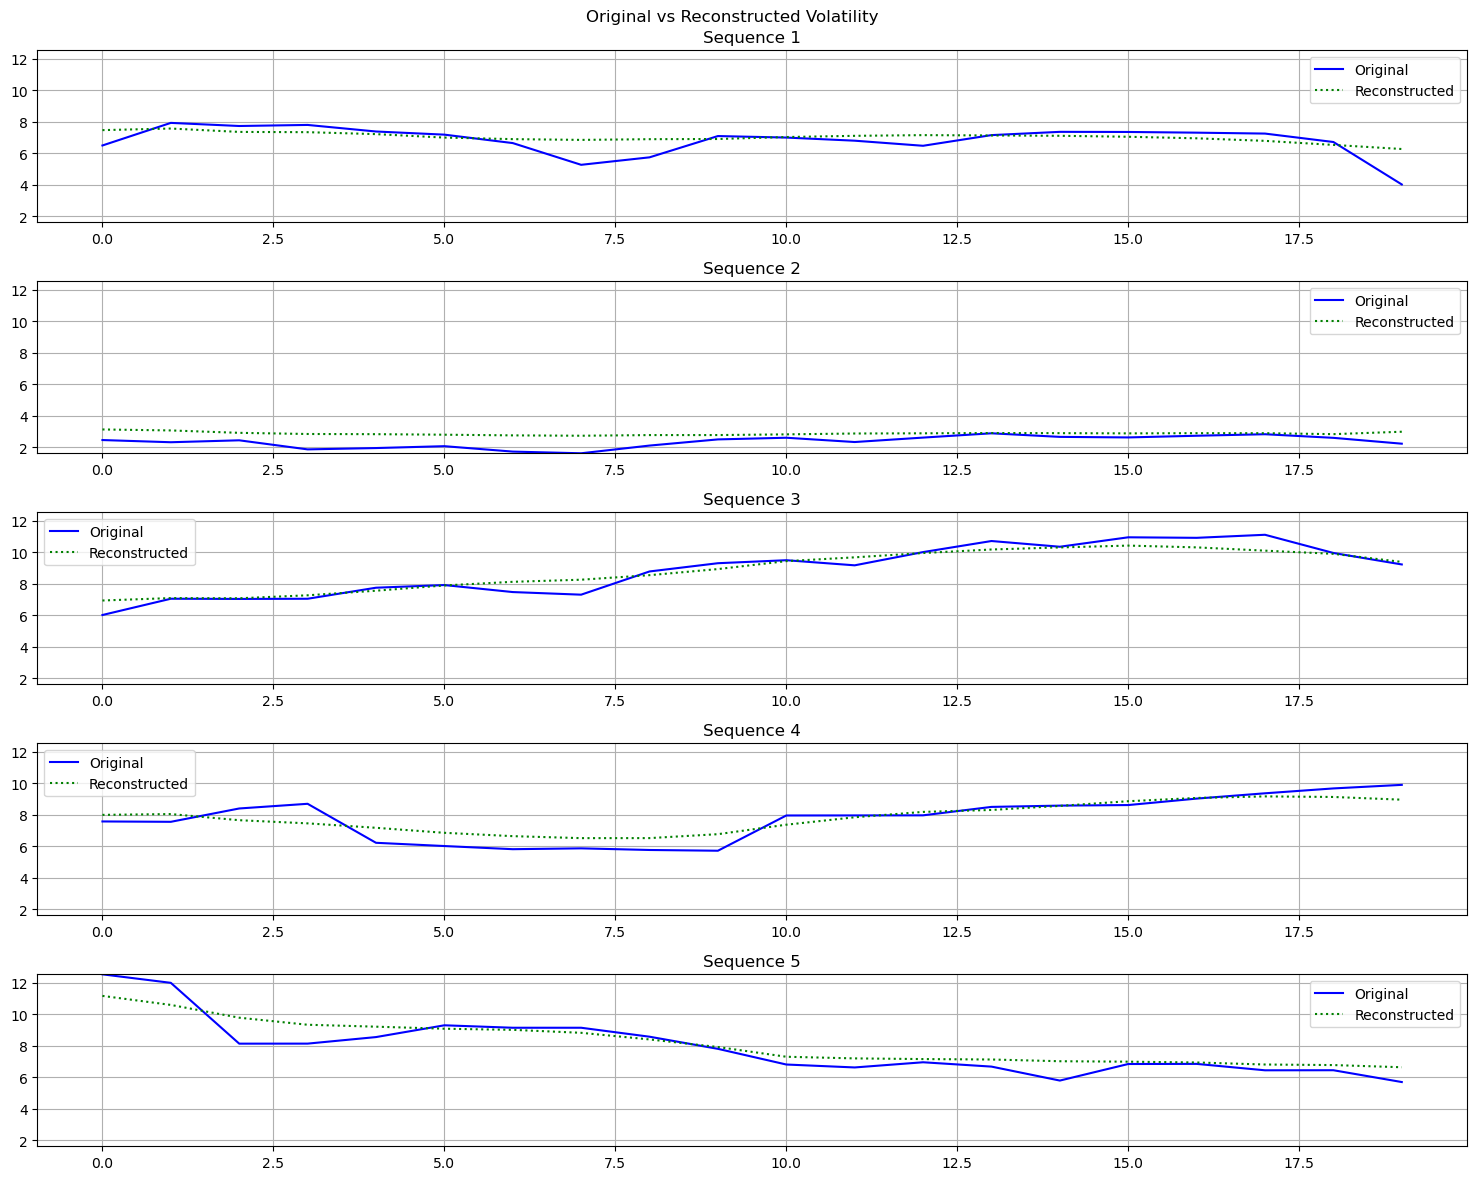

In [188]:
vae.eval()

# 5 random sequences for visualization
indices = torch.randperm(len(train_loader.dataset))[:5]
temporal_seqs = torch.stack([train_loader.dataset[i]['data'] for i in indices]).to(device)

# reconstructed sequences
with torch.no_grad():
    # VAE reconstructions
    mu, log_var = vae.encode(temporal_seqs)
    real_reconstructed_seqs = vae.decode(mu)
    
    # predicted reconstructions from latent space
    reconstructed_seqs = vae.decode(mu)

logger.info(f"Original sequences shape: {temporal_seqs.shape}")
logger.info(f"Reconstructed sequences shape: {reconstructed_seqs.shape}")
logger.info(f"VAE reconstructed sequences shape: {real_reconstructed_seqs.shape}")

fig, axes = plt.subplots(5, 1, figsize=(15, 12))
fig.suptitle('Original vs Reconstructed Volatility')

#  global min/max from original
all_orig_seqs = []
for i in range(5):
    all_orig_seqs.append(temporal_seqs[i,:,0].cpu().numpy())
y_min = min([seq.min() for seq in all_orig_seqs])
y_max = max([seq.max() for seq in all_orig_seqs])

for i in range(5):
    orig_seq = temporal_seqs[i,:,0].cpu().numpy()
    vae_recon_seq = real_reconstructed_seqs[i,:,0].cpu().numpy()
    
    # Plot
    axes[i].plot(orig_seq, label='Original', color='blue')
    axes[i].plot(vae_recon_seq, label='Reconstructed', color='green', linestyle=':')
    axes[i].set_title(f'Sequence {i+1}')
    axes[i].set_ylim(y_min, y_max)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


### Save

In [189]:
# save the trained VAE model
model_save_path = 'best_pretrained_temporal.pt'
torch.save(vae.state_dict(), model_save_path)
logger.info(f"Saved VAE model to {model_save_path}")

2025-01-18 00:53:15,951 - INFO - Saved VAE model to best_pretrained_temporal.pt


### Load

In [190]:
# load the trained VAE model
model_load_path = 'best_pretrained_temporal.pt'  
vae.load_state_dict(torch.load(model_load_path))
logger.info(f"Loaded VAE model from {model_load_path}")

2025-01-18 00:53:16,979 - INFO - Loaded VAE model from best_pretrained_temporal.pt


### Get embeddings

In [191]:
# get all latent embeddings from VAE
logger.info("Generating latent embeddings...")
all_latent_embeddings = []
all_dates = []

vae.eval()
with torch.no_grad():
    for batch in train_loader:
        temporal_seq = batch['data'].to(device)
        date = batch['date']
        mu, _ = vae.encode(temporal_seq)
        all_latent_embeddings.append(mu.cpu())
        all_dates.extend(date)

# concatenate all embeddings
all_latent_embeddings = torch.cat(all_latent_embeddings, dim=0).numpy()

2025-01-18 00:53:18,026 - INFO - Generating latent embeddings...


### Visualize embeddings if 3d

In [192]:
dates = pd.to_datetime(all_dates)
years = pd.Series(dates).dt.year

df = pd.DataFrame({
    'Date': all_dates,
    'x': all_latent_embeddings[:, 0],
    'y': all_latent_embeddings[:, 1], 
    'z': all_latent_embeddings[:, 2],
    'Year': years
})

fig = px.scatter_3d(
    df, x='x', y='y', z='z',
    color='Year',
    hover_data=['Date'],
    title='VAE Latent Space Visualization',
    opacity=0.8,
    color_continuous_scale='rainbow',
    color_continuous_midpoint=years.mean(),
    width=800,
    height=800
)

fig.update_traces(
    marker=dict(
        size=3,
        line=dict(width=0.1, color='rgba(255,255,255,0.1)')
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2', 
        zaxis_title='Dimension 3'
    ),
    template='plotly_dark',
    coloraxis_colorbar_title='Year',
    coloraxis_colorbar=dict(
        len=0.8,
        thickness=15,
        tickmode='linear',
        dtick=1
    )
)

fig.show()

### Visualize with tSNE

In [193]:
import umap
import plotly.express as px
import pandas as pd
from datetime import datetime

In [194]:
reducer = umap.UMAP(n_components=3, random_state=42)
latent_3d = reducer.fit_transform(all_latent_embeddings)

c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [279]:
dates = pd.to_datetime(all_dates)
years = pd.Series(dates).dt.year
year_ranks = pd.Series(years).rank(method='dense')

df = pd.DataFrame({
    'Date': all_dates,
    'x': latent_3d[:, 0],
    'y': latent_3d[:, 1],
    'z': latent_3d[:, 2],
    'Year': years
})

fig = px.scatter_3d(
    df, x='x', y='y', z='z',
    color='Year',
    hover_data=['Date'],
    title='UMAP Latent Space Visualization',
    opacity=0.7,
    color_continuous_scale='rainbow', 
    color_continuous_midpoint=years.mean(),
    width=800,  
    height=800  
)

fig.update_traces(
    marker=dict(
        size=5,
        line=dict(width=0.2, color='rgba(255,255,255,0.2)')
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    template='plotly_dark', 
    coloraxis_colorbar_title='Year', 
    coloraxis_colorbar=dict(
        len=0.8,
        thickness=15,
        tickmode='linear',
        dtick=1
    )
)

fig.show()

logger.info("UMAP dimensionality reduction completed")


2025-01-18 03:08:07,315 - INFO - UMAP dimensionality reduction completed


In [276]:
dates = pd.to_datetime(all_dates)
# Extract years and holidays
years = dates.year

# major US holidays
is_new_years = (dates.month == 1) & (dates.day == 1)
is_mlk_day = (dates.month == 1) & (dates.day.isin([15,16,17,18,19,20,21])) & (dates.dayofweek == 0) 
is_presidents_day = (dates.month == 2) & (dates.day.isin([15,16,17,18,19,20,21])) & (dates.dayofweek == 0)
is_memorial_day = (dates.month == 5) & (dates.day >= 25) & (dates.dayofweek == 0)
is_juneteenth = (dates.month == 6) & (dates.day == 19)
is_independence_day = (dates.month == 7) & (dates.day == 4)
is_labor_day = (dates.month == 9) & (dates.day <= 7) & (dates.dayofweek == 0)
is_columbus_day = (dates.month == 10) & (dates.day.isin([8,9,10,11,12,13,14])) & (dates.dayofweek == 0) 
is_veterans_day = (dates.month == 11) & (dates.day == 11)
is_thanksgiving = (dates.month == 11) & (dates.day.isin([22,23,24,25,26,27,28])) & (dates.dayofweek == 3)
is_christmas = (dates.month == 12) & (dates.day == 25)

# holidays creating long weekends (these holidays are long weekends and not holidays for analysis)
is_long_weekend = (
    (is_mlk_day | is_presidents_day | is_memorial_day | is_labor_day | is_columbus_day) |
    ((is_new_years | is_juneteenth | is_independence_day | is_veterans_day | is_christmas) & 
     (dates.dayofweek.isin([0, 4])))  # Monday or Friday
)

# regular weekends
is_weekend = (dates.dayofweek.isin([5, 6])) & ~is_long_weekend

# regular Mondays excluding holidays and long weekends
is_monday = (dates.dayofweek == 0) & ~is_long_weekend & ~is_holiday

# all holidays (excluding long weekends)
is_holiday = (
    (is_new_years | is_juneteenth | is_independence_day | is_veterans_day |
    is_thanksgiving | is_christmas) & ~is_long_weekend
)

df = pd.DataFrame({
    'Date': all_dates,
    'x': latent_3d[:, 0],
    'y': latent_3d[:, 1], 
    'z': latent_3d[:, 2],
    'Year': years,
    'Holiday': is_holiday,
    'LongWeekend': is_long_weekend,
    'Weekend': is_weekend,
    'Monday': is_monday
})

fig = px.scatter_3d(
    df[~(df['Holiday'] | df['LongWeekend'] | df['Weekend'] | df['Monday'])], 
    x='x', y='y', z='z',
    hover_data=['Date'],
    title='UMAP Latent Space Visualization - Holidays and Weekends',
    opacity=0.3,
    width=800,
    height=800
)

fig.update_traces(
    marker=dict(
        color='grey',
        size=4,
        line=dict(width=0.2, color='rgba(255,255,255,0.2)')
    ),
    name='Weekday'
)

fig.add_scatter3d(
    x=df[df['Monday']]['x'],
    y=df[df['Monday']]['y'],
    z=df[df['Monday']]['z'],
    mode='markers',
    marker=dict(
        color='blue',
        size=5,
        symbol='circle',
        line=dict(width=0.2, color='rgba(255,255,255,0.2)')
    ),
    hovertext=df[df['Monday']]['Date'],
    name='After Weekend'
)

fig.add_scatter3d(
    x=df[df['LongWeekend']]['x'],
    y=df[df['LongWeekend']]['y'],
    z=df[df['LongWeekend']]['z'],
    mode='markers',
    marker=dict(
        color='red',
        size=5,
        symbol='circle',
        line=dict(width=0.2, color='rgba(255,255,255,0.2)')
    ),
    hovertext=df[df['LongWeekend']]['Date'],
    name='After Long Weekend'
)

fig.add_scatter3d(
    x=df[df['Holiday']]['x'],
    y=df[df['Holiday']]['y'],
    z=df[df['Holiday']]['z'],
    mode='markers',
    marker=dict(
        color='green',
        size=5,
        symbol='circle',
        line=dict(width=0.2, color='rgba(255,255,255,0.2)')
    ),
    hovertext=df[df['Holiday']]['Date'],
    name='After Holiday'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    template='plotly_dark',
    showlegend=True
)

fig.show()

logger.info("UMAP dimensionality reduction completed")


2025-01-18 02:42:58,157 - INFO - UMAP dimensionality reduction completed


In [197]:
# Load and align data
matched_temporal_data, matched_text_data = load_and_align_data(
    "temporal_data_10window",
    "text_data"
)

2025-01-18 00:53:47,430 - INFO - Found 919 matching dates


In [198]:
temporal_lens = [len(seq) for seq in matched_temporal_data]
text_lens = [len(text) for text in matched_text_data]

if len(set(temporal_lens)) != 1 or len(set(text_lens)) != 1:
    logger.warning("Found sequences with different lengths")
    
    # get target lengths (most common length)
    target_temporal_len = max(set(temporal_lens), key=temporal_lens.count)
    target_text_len = max(set(text_lens), key=text_lens.count)
    
    # filter to keep only sequences matching target length
    valid_indices = [i for i in range(len(matched_temporal_data)) 
                    if len(matched_temporal_data[i]) == target_temporal_len
                    and len(matched_text_data[i]) == target_text_len]
    
    matched_temporal_data = [matched_temporal_data[i] for i in valid_indices]
    matched_text_data = [matched_text_data[i] for i in valid_indices]
    
    logger.info(f"Kept {len(valid_indices)} sequences with temporal length {target_temporal_len} and text length {target_text_len}")

In [199]:
aligned_dataset = AlignedDataset(matched_temporal_data, matched_text_data, seq_len)
aligned_loader = DataLoader(
    aligned_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [200]:
train_size = int(0.8 * len(aligned_dataset))
test_size = len(aligned_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(aligned_dataset, [train_size, test_size])

logger.info(f"Total dataset size: {len(aligned_dataset)}")
logger.info(f"Training set size: {len(train_dataset)}")
logger.info(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False
)

2025-01-18 00:53:50,858 - INFO - Total dataset size: 919
2025-01-18 00:53:50,859 - INFO - Training set size: 735
2025-01-18 00:53:50,860 - INFO - Test set size: 184


In [240]:
predictor = LatentPredictor(
    bert_dim=768,  # BERT 
    latent_dim=8  # VAE dimension
).to(device)

In [241]:
predictor_optimizer = torch.optim.AdamW(predictor.parameters(), lr=5e-4)

In [242]:
logger.info("Training predictor...")
vae.eval()  # VAE eval mode
predictor.train()

2025-01-18 01:05:00,369 - INFO - Training predictor...


LatentPredictor(
  (input_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): GELU(approximate='none')
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): GELU(approximate='none')
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplace=False)
    )
  )
  (feature_extraction): Sequential(
    (0): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): GELU(approximate='none')
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bi

In [243]:
predictor_epochs = 10000

In [253]:
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 20
patience_counter = 0
best_model_state = None

for epoch in range(predictor_epochs):
    # Training
    predictor.train()
    epoch_loss = 0
    for temporal_seq, text_emb, _ in train_loader:   
        temporal_seq = temporal_seq.to(device)
        text_emb = text_emb.to(device)
        
        if temporal_seq.dim() == 2:
            temporal_seq = temporal_seq.unsqueeze(-1)  # [batch_size, seq_len] -> [batch_size, seq_len, 1]
        
        with torch.no_grad():
            mu, _ = vae.encode(temporal_seq)
        
        predicted_z = predictor(text_emb)
        
        loss = F.mse_loss(predicted_z, mu)
        
        predictor_optimizer.zero_grad()
        loss.backward()
        predictor_optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Test
    predictor.eval()
    test_loss = 0
    with torch.no_grad():
        for temporal_seq, text_emb, _ in test_loader:
            temporal_seq = temporal_seq.to(device)
            text_emb = text_emb.to(device)
            
            if temporal_seq.dim() == 2:
                temporal_seq = temporal_seq.unsqueeze(-1)
                
            mu, _ = vae.encode(temporal_seq)
            predicted_z = predictor(text_emb)
            loss = F.mse_loss(predicted_z, mu)
            test_loss += loss.item()
            
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    logger.info(f'Predictor Epoch {epoch+1}, Train Loss: {avg_train_loss:.15f}, Test Loss: {avg_test_loss:.15f}')

    # Early stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = predictor.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        logger.info(f'Early stopping triggered after {epoch+1} epochs')
        predictor.load_state_dict(best_model_state)  # Restore best model
        break

2025-01-18 01:06:24,050 - INFO - Predictor Epoch 1, Train Loss: 0.285094608863195, Test Loss: 0.416484385728836
2025-01-18 01:06:24,135 - INFO - Predictor Epoch 2, Train Loss: 0.280769842366378, Test Loss: 0.380401089787483
2025-01-18 01:06:24,225 - INFO - Predictor Epoch 3, Train Loss: 0.280685668190320, Test Loss: 0.398075610399246
2025-01-18 01:06:24,304 - INFO - Predictor Epoch 4, Train Loss: 0.284030730525653, Test Loss: 0.411319807171822
2025-01-18 01:06:24,377 - INFO - Predictor Epoch 5, Train Loss: 0.281150609254837, Test Loss: 0.385209158062935
2025-01-18 01:06:24,448 - INFO - Predictor Epoch 6, Train Loss: 0.278931533296903, Test Loss: 0.393365293741226
2025-01-18 01:06:24,520 - INFO - Predictor Epoch 7, Train Loss: 0.281583517789841, Test Loss: 0.399032086133957
2025-01-18 01:06:24,590 - INFO - Predictor Epoch 8, Train Loss: 0.279802121222019, Test Loss: 0.379358023405075
2025-01-18 01:06:24,663 - INFO - Predictor Epoch 9, Train Loss: 0.279915491739909, Test Loss: 0.38444197

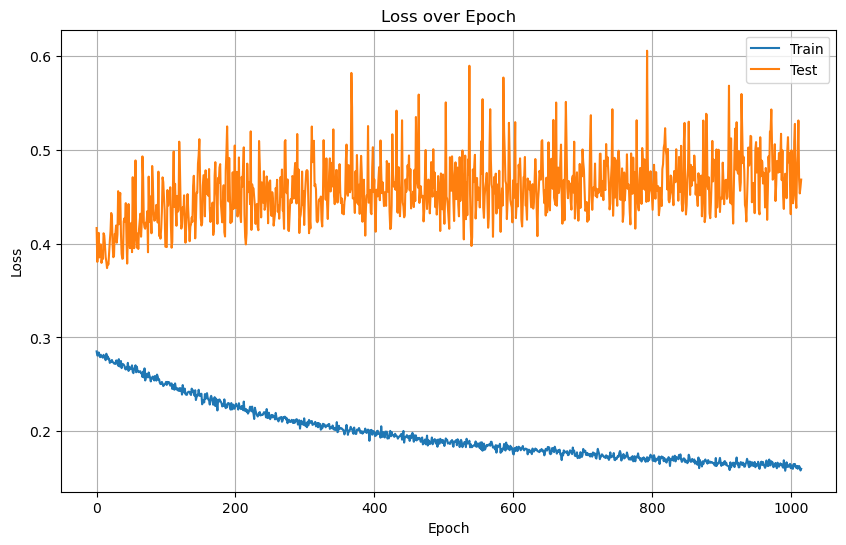

In [254]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [255]:
# Save mapper
torch.save(predictor.state_dict(), 'best_predictor.pt')

In [256]:
# get sample data
sample_indices = torch.randint(0, len(test_loader.dataset), (5,))
sample_data = [test_loader.dataset[i] for i in sample_indices]

# extract temporal sequences and text embeddings
temporal_seqs = torch.stack([data[0] for data in sample_data]).to(device)
text_embs = torch.stack([data[1] for data in sample_data]).to(device)

# add dimension
if temporal_seqs.dim() == 2:
    temporal_seqs = temporal_seqs.unsqueeze(-1)

# get VAE latent embeddings
with torch.no_grad():
    mu, _ = vae.encode(temporal_seqs)

# get predictor latent embeddings
predicted_z = predictor(text_embs)

In [257]:
# decode predicted latent vectors back to temporal sequences
with torch.no_grad():
    reconstructed_seqs = vae.decode(predicted_z)
    # get reconstructed sequences from original temporal data through VAE
    real_reconstructed_seqs = vae.decode(mu)

# print shape
logger.info(f"Original sequences shape: {temporal_seqs.shape}")
logger.info(f"Reconstructed sequences shape: {reconstructed_seqs.shape}")
logger.info(f"VAE reconstructed sequences shape: {real_reconstructed_seqs.shape}")


2025-01-18 01:12:06,674 - INFO - Original sequences shape: torch.Size([5, 20, 1])
2025-01-18 01:12:06,675 - INFO - Reconstructed sequences shape: torch.Size([5, 20, 1])
2025-01-18 01:12:06,675 - INFO - VAE reconstructed sequences shape: torch.Size([5, 20, 1])


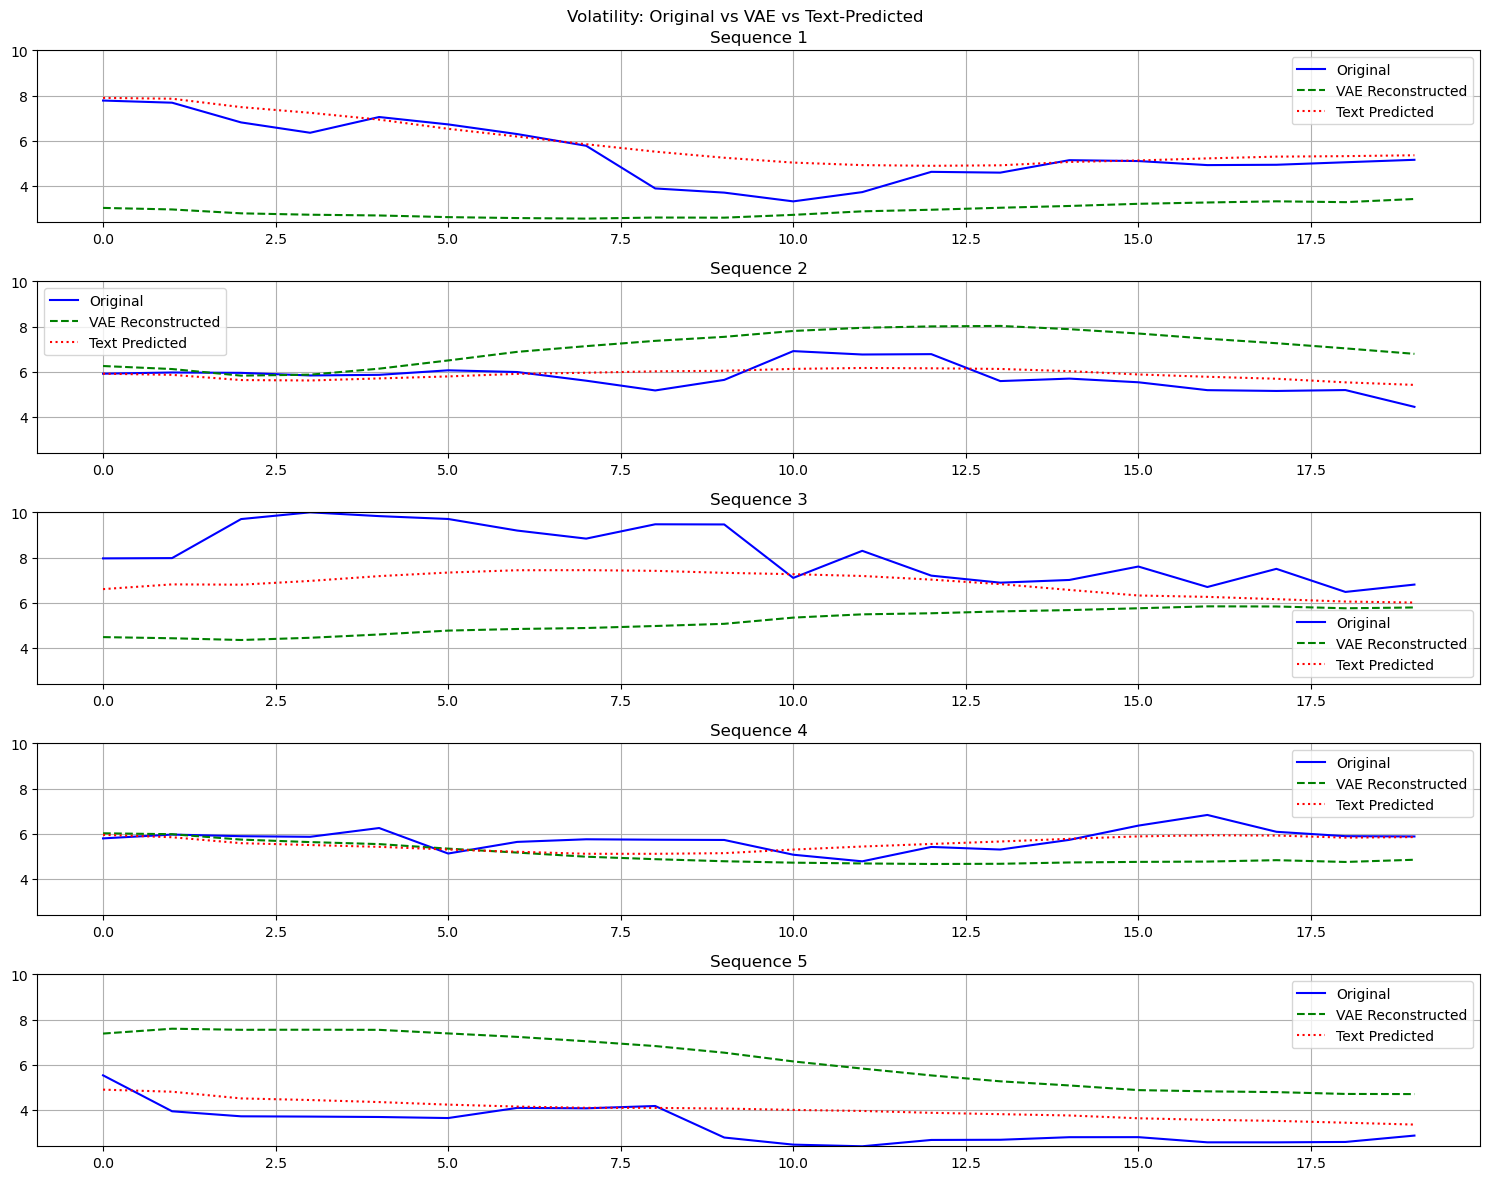

In [278]:
fig, axes = plt.subplots(5, 1, figsize=(15, 12))
fig.suptitle('Volatility: Original vs VAE vs Text-Predicted')

# global min/max
all_seqs = []
for i in range(5):
    all_seqs.extend([
        temporal_seqs[i,:,0].cpu().numpy(),
        real_reconstructed_seqs[i,:,0].cpu().numpy(),
        reconstructed_seqs[i,:,0].cpu().numpy()
    ])
y_min = min([seq.min() for seq in all_seqs])
y_max = max([seq.max() for seq in all_seqs])

for i in range(5):
    # get data
    orig_seq = temporal_seqs[i,:,0].cpu().numpy()
    vae_recon_seq = real_reconstructed_seqs[i,:,0].cpu().numpy()
    text_pred_seq = reconstructed_seqs[i,:,0].cpu().numpy()
    
    # plot
    axes[i].plot(orig_seq, label='Original', color='blue')
    axes[i].plot(vae_recon_seq, label='VAE Reconstructed', color='green', linestyle='--')
    axes[i].plot(text_pred_seq, label='Text Predicted', color='red', linestyle=':')
    axes[i].set_title(f'Sequence {i+1}')
    axes[i].set_ylim(y_min, y_max)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Calculate error

In [261]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [262]:
print("Test loader batch components:")
for batch in test_loader:
    print(f"Number of items in batch: {len(batch)}")
    print("\nComponents:")
    for i, item in enumerate(batch):
        print(f"Item {i+1}:")
        print(f"  Type: {type(item)}")
        if isinstance(item, tuple):
            print(f"  Contents: {[type(x) for x in item]}")
        else:
            print(f"  Shape: {item.shape}")
            print(f"  Device: {item.device}")
    break

Test loader batch components:
Number of items in batch: 3

Components:
Item 1:
  Type: <class 'torch.Tensor'>
  Shape: torch.Size([128, 20])
  Device: cpu
Item 2:
  Type: <class 'torch.Tensor'>
  Shape: torch.Size([128, 768])
  Device: cpu
Item 3:
  Type: <class 'tuple'>
  Contents: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'st

In [263]:
# test
test_pred_mse = []
test_recon_mse = []

for batch in test_loader:
    temporal_seqs, text_embs, _ = batch
    temporal_seqs = temporal_seqs.to(device)
    text_embs = text_embs.to(device)

    if temporal_seqs.dim() == 2:
        temporal_seqs = temporal_seqs.unsqueeze(-1)

    with torch.no_grad():
        mu, _ = vae.encode(temporal_seqs)
        predicted_z = predictor(text_embs)
        reconstructed_seqs = vae.decode(predicted_z)
        vae_recon_seqs = vae.decode(mu)

    for i in range(temporal_seqs.shape[0]):
        orig = temporal_seqs[i,:,0].cpu().numpy()
        pred = reconstructed_seqs[i,:,0].cpu().numpy()
        recon = vae_recon_seqs[i,:,0].cpu().numpy()
        
        pred_mse = mean_squared_error(orig, pred)
        recon_mse = mean_squared_error(orig, recon)
        
        test_pred_mse.append(pred_mse)
        test_recon_mse.append(recon_mse)

test_pred_mse = np.array(test_pred_mse)
test_recon_mse = np.array(test_recon_mse)

print("Test Data Statistics:")
print(f"Predicted sequences - Mean MSE: {np.mean(test_pred_mse):.6f}, Std MSE: {np.std(test_pred_mse):.6f}")
print(f"Reconstructed sequences - Mean MSE: {np.mean(test_recon_mse):.6f}, Std MSE: {np.std(test_recon_mse):.6f}")

# train
train_pred_mse = []
train_recon_mse = []

for batch in train_loader:
    temporal_seqs, text_embs, _ = batch
    temporal_seqs = temporal_seqs.to(device)
    text_embs = text_embs.to(device)

    if temporal_seqs.dim() == 2:
        temporal_seqs = temporal_seqs.unsqueeze(-1)

    with torch.no_grad():
        mu, _ = vae.encode(temporal_seqs)
        predicted_z = predictor(text_embs)
        reconstructed_seqs = vae.decode(predicted_z)
        vae_recon_seqs = vae.decode(mu)

    for i in range(temporal_seqs.shape[0]):
        orig = temporal_seqs[i,:,0].cpu().numpy()
        pred = reconstructed_seqs[i,:,0].cpu().numpy()
        recon = vae_recon_seqs[i,:,0].cpu().numpy()
        
        pred_mse = mean_squared_error(orig, pred)
        recon_mse = mean_squared_error(orig, recon)
        
        train_pred_mse.append(pred_mse)
        train_recon_mse.append(recon_mse)

train_pred_mse = np.array(train_pred_mse)
train_recon_mse = np.array(train_recon_mse)

print("\nTrain Data Statistics:")
print(f"Predicted sequences - Mean MSE: {np.mean(train_pred_mse):.6f}, Std MSE: {np.std(train_pred_mse):.6f}")
print(f"Reconstructed sequences - Mean MSE: {np.mean(train_recon_mse):.6f}, Std MSE: {np.std(train_recon_mse):.6f}")


Test Data Statistics:
Predicted sequences - Mean MSE: 8.083219, Std MSE: 14.418576
Reconstructed sequences - Mean MSE: 0.398361, Std MSE: 0.166994

Train Data Statistics:
Predicted sequences - Mean MSE: 3.241887, Std MSE: 16.363720
Reconstructed sequences - Mean MSE: 0.404103, Std MSE: 0.183357
